# 📊 Predição de séries temporais com SARIMA

## 📊 Contexto do Projeto

📁 **Dataset utilizado:**  
O conjunto de dados analisado é o clássico **Air Passengers Dataset**, que contém o número mensal de passageiros de uma companhia aérea internacional ao longo do tempo.

🗓️ **Período de observação:**  
De **janeiro de 1949** até **dezembro de 1960**, totalizando **144 registros mensais**.

---

### 🔍 Por que esse dataset é interessante?

Este dataset é frequentemente utilizado para estudos e modelagens de **séries temporais**, devido às suas características bem definidas:

- 📈 **Tendência:**  
  O número de passageiros cresce ao longo dos anos, indicando uma **tendência de alta**.

- 📆 **Sazonalidade:**  
  A série exibe um **padrão sazonal anual**, ou seja, o comportamento se repete aproximadamente a cada **12 meses**.

- 🌪️ **Flutuações aleatórias:**  
  Existem pequenas **variações** além da tendência e sazonalidade, que podem estar relacionadas a **ruídos** ou **eventos específicos**.

---

### 🧠 Estratégia de Modelagem

📌 Para este estudo, foi escolhido o modelo **SARIMA** (*Seasonal AutoRegressive Integrated Moving Average*), pois:

> ⚠️ A série possui uma **sazonalidade explícita** — o que torna o SARIMA uma opção ideal para capturar tanto a tendência quanto os ciclos sazonais.


## Imports

In [1]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Pipeline 

### Carregamento dos dados 

In [2]:
# Carregar o dataset AirPassengers
data = sm.datasets.get_rdataset('AirPassengers', package='datasets')
df = data.data

#Renomeando colunas
df = df.rename(columns={'time':'Month', 'value':'Passengers'})

#Convertendo valores decimais em data
def decimal_to_date(decimal):
    year = int(decimal)
    # Extrai fração e converte em mês
    month_fraction = decimal - year
    month = int(round(month_fraction * 12)) + 1
    if month > 12:
        month = 1
        year += 1
    return pd.Timestamp(year=year, month=month, day=1)

df['Month'] = df.Month.apply(decimal_to_date)

#Setando a coluna mês para index
df.reset_index()
df.set_index('Month', inplace=True)

### Exploração dos dados (EDA)

#### Visualização inicial dos dados

In [3]:
df.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

#### Resumo estatístico das variáveis numéricas

In [4]:
df.describe()

Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000

#### Verificar a existência de valores nulos

Não existem valores nulos

In [5]:
df.isnull().sum()

Passengers    0
dtype: int64

#### Visualizando a série temporal: Verificando a exitência de sazonalidade

Analisando visualmente o gráfico, vemos que existem padrões que se repetem o que nos remete a existência de sazonalidade

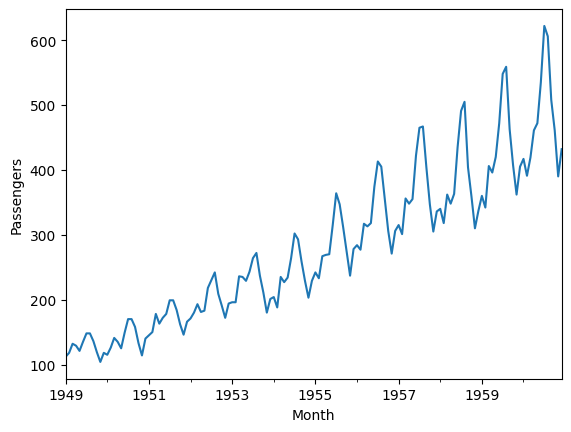

In [6]:
df.Passengers.plot()
plt.ylabel('Passengers')
plt.show()

#### Vericar de quanto em quanto tempo se repetem os ciclos de sazonalidade

Analisando o gráfico ACF vemos que a sazonalidade acontece de 12 em 12 meses, ou seja, a cada ano

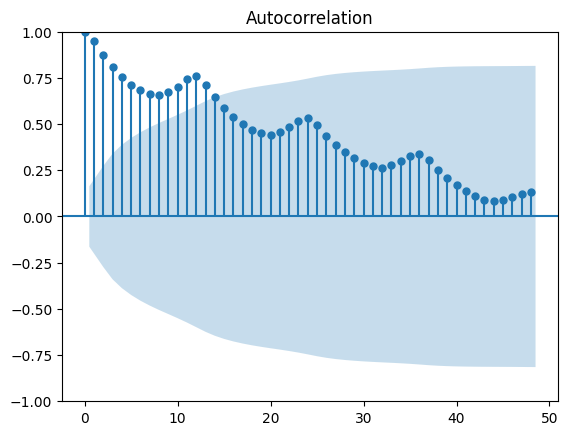

In [7]:
plot_acf(df, lags=48)  # lags ajustados conforme o necessário
plt.show()

#### Decompondo a série temporal em componentes (Tendência, Sazonalidade e Resíduos)

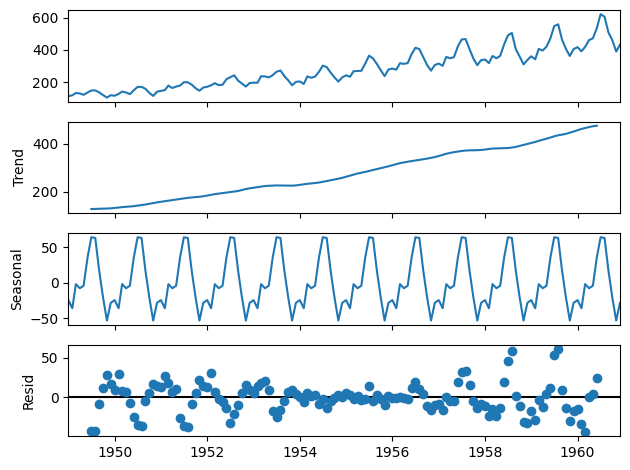

In [8]:
# Decomposição com o período de 12 meses
result = seasonal_decompose(df, model='additive', period=12)
result.plot()
plt.show()

#### Aplicando a diferenciação sazonal

Como a série é sazona em 12, aplicamos a diferenciação sazonal para remover a sazonalidade da séria e deixá-la estacionária para facilitar modelagem e escolha de parẽmetros do modelo

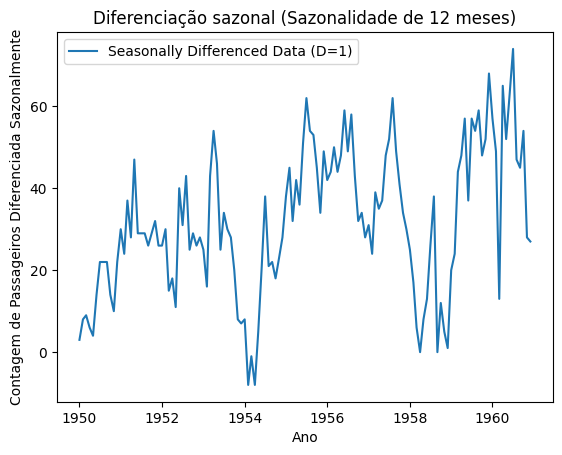

In [9]:
# Diferenciação sazonal de ordem 1 (D=1)
df_seasonal_diff = df.diff(12).dropna()

# Plot da série diferenciada sazonalmente
plt.plot(df_seasonal_diff, label="Seasonally Differenced Data (D=1)")
plt.title("Diferenciação sazonal (Sazonalidade de 12 meses)")
plt.xlabel("Ano")
plt.ylabel("Contagem de Passageiros Diferenciada Sazonalmente")
plt.legend()
plt.show()

#### Realizando o teste de estacionaridade ADF

Realizando o teste de estacionaridade, vemos que com a diferenciação sazonal, a séria passou no teste de estacionaridade

In [10]:
def testar_adf(serie_temporal):
    """
    Realiza o teste ADF (Augmented Dickey-Fuller) para verificar se a série temporal é estacionária.
    
    Parâmetros:
    serie_temporal (pandas.Series): A série temporal a ser testada.
    
    Retorna:
    str: Mensagem com o resultado do teste.
    """
    
    # Realiza o Teste ADF
    resultado = adfuller(serie_temporal)
    
    # Estatísticas do Teste
    estatistica_adf = resultado[0]
    valor_p = resultado[1]
    lags_usados = resultado[2]
    num_observacoes = resultado[3]
    valores_criticos = resultado[4]
    
    # Exibe os resultados
    print('Estatística ADF:', estatistica_adf)
    print('Valor-p:', valor_p)
    print('Número de lags usados:', lags_usados)
    print('Número de observações:', num_observacoes)
    print('Valores críticos:')
    for chave, valor in valores_criticos.items():
        print(f'\t{chave}: {valor}')
    
    # Interpretação do resultado
    if valor_p < 0.05:
        return "Rejeita a hipótese nula: A série é estacionária."
    else:
        return "Não rejeita a hipótese nula: A série não é estacionária."

testar_adf(df_seasonal_diff)

Estatística ADF: -3.383020726492481
Valor-p: 0.011551493085514952
Número de lags usados: 1
Número de observações: 130
Valores críticos:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


'Rejeita a hipótese nula: A série é estacionária.'

### Teste de Modelos: SARIMA

#### Definição dos parâmetros do modelo: p, q, m e d

- Visualizando os gráficos ACF e PACF vamos definir os parâmetros do modelo SARIMA:

- O valor de d é igual a 1 pq foi aplicada a diferenciação sazonal de primeira ordem.

- O valor de m que seria a frequência sazonal serie de 12 mêses definido na análise explorarória acima.

- Analizando o AFC vemos que o lado posterior acaba sendo menor que o anterior e que o valor de q pode ser muito menor (q = 0, q = 1)

- Analisando o PACF vemos que a partir do segundo lag, vemos uma queda brusca isso remete que o valor de p é muito pequeno (p = 1 ou p = 2).

<Figure size 1200x600 with 0 Axes>

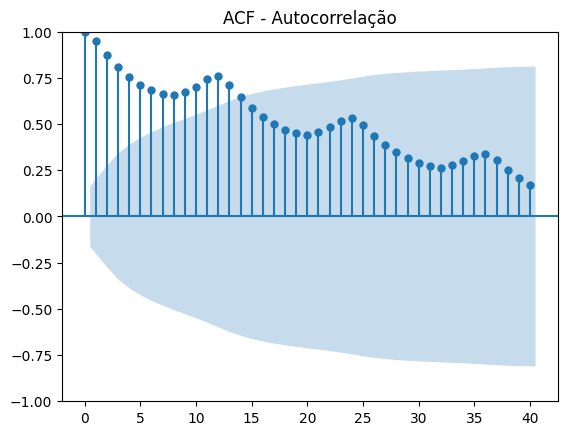

<Figure size 1200x600 with 0 Axes>

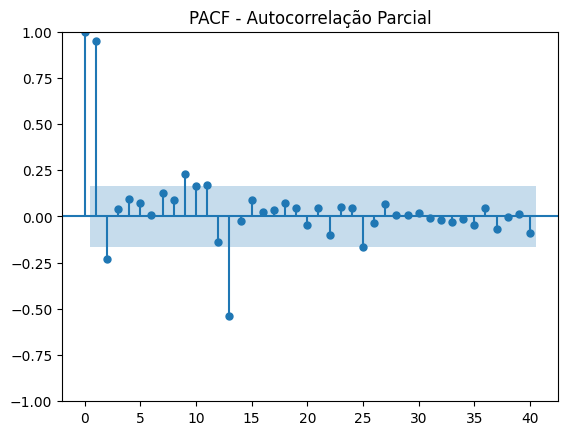

In [11]:
# Gerar gráfico de ACF
plt.figure(figsize=(12, 6))
plot_acf(df, lags=40)  # Ajuste o número de lags conforme necessário
plt.title("ACF - Autocorrelação")
plt.show()

# Gerar gráfico de PACF
plt.figure(figsize=(12, 6))
plot_pacf(df, lags=40)  # Ajuste o número de lags conforme necessário
plt.title("PACF - Autocorrelação Parcial")
plt.show()

#### Definição dos parâmetros do modelo: P Q e D

- No grafico PACF vemos o primeiro e segundo lag com picos significativos ou seja ou valor o valor de P pode assumir (P = 1 ou P 2).
- O valor de D é a ordem de diferenciação, como a diferenciação sazonal é de ordem 1 então (D = 1).
- No gráfico ACF os lags sazonais começam em um pico alto, vão diminuindo ao longo do tempo e chegando a zero o que indica que o valor de Q pode assumir (Q = 1).

<Figure size 1200x600 with 0 Axes>

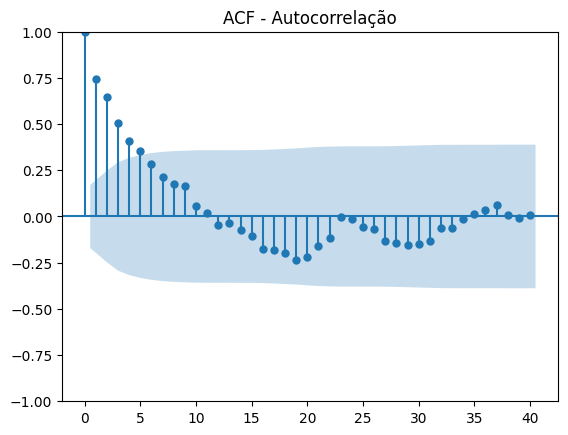

<Figure size 1200x600 with 0 Axes>

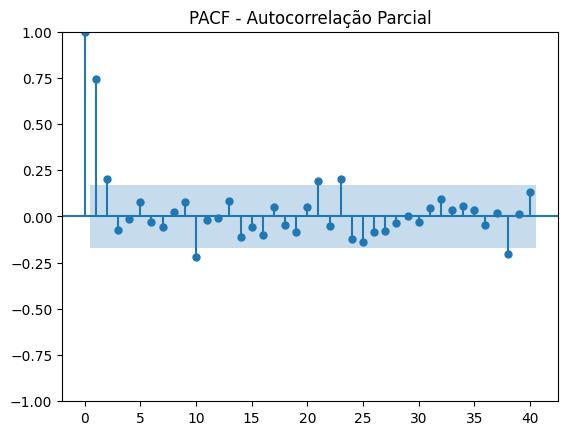

In [12]:
# Gerar gráfico de ACF
plt.figure(figsize=(12, 6))
plot_acf(df_seasonal_diff, lags=40)  # Ajuste o número de lags conforme necessário
plt.title("ACF - Autocorrelação")
plt.show()

# Gerar gráfico de PACF
plt.figure(figsize=(12, 6))
plot_pacf(df_seasonal_diff, lags=40)  # Ajuste o número de lags conforme necessário
plt.title("PACF - Autocorrelação Parcial")
plt.show()

#### Treinamento do modelo SARIMA

In [13]:
# Treinamento do SARIMA

df.index.freq = 'MS'
model = SARIMAX(df['Passengers'], order=(1,1,1), seasonal_order=(1,1,1,12))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.52844D+00    |proj g|=  8.65844D-02

At iterate    5    f=  3.52337D+00    |proj g|=  3.73531D-02


 This problem is unconstrained.



At iterate   10    f=  3.51577D+00    |proj g|=  4.96158D-03

At iterate   15    f=  3.51498D+00    |proj g|=  1.97602D-03

At iterate   20    f=  3.51493D+00    |proj g|=  7.03168D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   3.242D-05   3.515D+00
  F =   3.5149263635006722     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


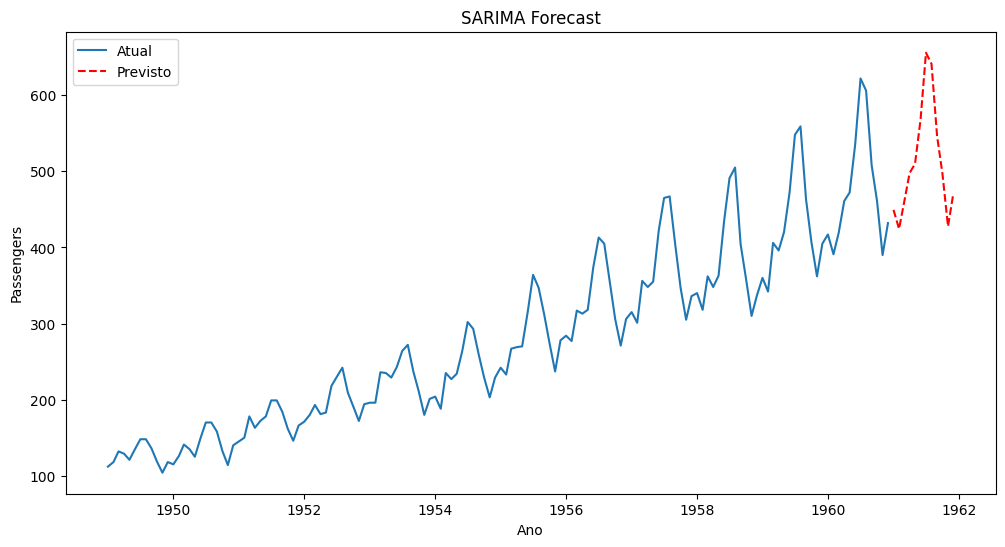

In [14]:
result = model.fit()

# Previsão de 12 meses a frente
forecast = result.forecast(steps=12)

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df, label="Atual")
plt.plot(forecast, label="Previsto", linestyle="dashed", color='red')
plt.title("SARIMA Forecast")
plt.xlabel("Ano")
plt.ylabel("Passengers")
plt.legend()
plt.show()

## 📈 Resumo dos Resultados do Forecast SARIMA

🔧 **Modelo ajustado:**  
Foi utilizado o modelo **SARIMA(1,1,1)(1,1,1,12)** para a série temporal de passageiros aéreos mensais. Esse modelo contempla:

- ✔️ **Diferenciação regular**
- 🔄 **Diferenciação sazonal com periodicidade anual (12 meses)**

---

### ⚙️ Processo de Otimização (L-BFGS-B)

Durante o ajuste, o modelo demonstrou **boa convergência** com os seguintes resultados:

- 📉 **Log-Likelihood** reduzido de **3.5284** para **3.5149**
- 🔁 **Convergência alcançada** após **23 iterações** e **27 avaliações de função**
- 📏 **Gradiente projetado final:** `3.24e-05`, indicando um **ajuste estável e eficiente**
- 🟢 **Mensagem de convergência:**  
  `"REL_REDUCTION_OF_F <= FACTR * EPSMCH"`  
  ✅ O critério de parada baseado na **redução relativa da função objetivo** foi atendido com sucesso

---

### 🔮 Previsão

Com o modelo validado, foi realizado um **forecast de 12 meses** à frente da série original, gerando previsões fundamentadas nos **padrões de tendência** e **sazonalidade** detectados ao longo dos dados históricos.
